In [1]:
import cv2
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np

In [2]:
class ResidualBlock(torch.nn.Module):
    def __init__(self,channels):
        super(ResidualBlock,self).__init__()
        self.channels = channels
        
        self.conv1 = nn.Conv2d(channels,channels,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(channels,channels,kernel_size=3,padding=1)
    
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        return F.relu(x+y)
    
class conv(nn.Module):
    def __init__(self,in_n,out_n,k_size=3,std=1,pad=0):
        super().__init__()
        self.forw=nn.Sequential(
            nn.Conv2d(in_n,out_n,kernel_size=k_size,stride = std,padding=pad),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.forw(x)

class convT(nn.Module):
    def __init__(self,in_n,out_n,k_size=4,std=2,pad=1,outpad=0):
        super().__init__()
        self.forw=nn.Sequential(
            nn.ConvTranspose2d(in_n,out_n,kernel_size=4,stride=2,padding=1,output_padding=outpad),            #[b,16,7,7] ———> [b,16,14,14]
            nn.ReLU(),
        )
    def forward(self, x):
        return self.forw(x)

#先对输入图片进行降采样
#将b*3*960*960转为b*128*60*60
class downsample(nn.Module):
    def __init__(self):
        super().__init__()
        self.forw=nn.Sequential(
                conv(3,16,5,1,2),
                nn.Conv2d(16,16,3),
                conv(16,32,pad=1),
                conv(32,64,pad=1),
        )
    def forward(self, x):
        return self.forw(x)
#对中间结果上采样，b*128*60*60转为b*3*960*960
class upsample(nn.Module):
    def __init__(self):
        super().__init__()
        self.forw=nn.Sequential(
                convT(64,32),
                convT(32,16),
                nn.ConvTranspose2d(16,16,3),
                convT(16,3),
        )
    def forward(self, x):
        return self.forw(x)

In [5]:
class mysample(nn.Module):
    def __init__(self):
        super().__init__()
        self.down = downsample()
        self.up = upsample()
    def forward(self, x):
        out = self.down(x)
        out = self.up(out)
        return out

#动物识别
class Net(nn.Module):#每层一个卷积、俩残差模块、一个池化，也就是6层，一共31层
    def __init__(self,num_class=10):
        super().__init__()
        self.layer1=nn.Sequential(nn.Conv2d(3,32,kernel_size=7,padding=1),#m*16*224*224
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2),#m*32*112*112
                                  ResidualBlock(32),
                                  ResidualBlock(32)
                                  )
        self.layer2=nn.Sequential(nn.Conv2d(32,64,kernel_size=3,padding=1),#m*64*112*112
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2),#m*64*56*56
                                  ResidualBlock(64),
                                  ResidualBlock(64)
                                  )
        self.layer3=nn.Sequential(nn.Conv2d(64,128,kernel_size=3,padding=1),#m*128*56*56
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2),#m*128*28*28
                                  ResidualBlock(128),
                                  ResidualBlock(128)
                                  )
        self.layer4=nn.Sequential(nn.Conv2d(128,256,kernel_size=3,padding=1),#m*128*28*28
                                  nn.BatchNorm2d(256),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2),#m*128*14*14
                                  ResidualBlock(256),
                                  ResidualBlock(256)
                                  )
        self.layer5=nn.Sequential(nn.Conv2d(256,512,kernel_size=3,padding=1),#m*512*14*14
                                  nn.BatchNorm2d(512),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2),#m*512*7*7
                                  ResidualBlock(512),
                                  ResidualBlock(512)
                                  )
        self.fc = nn.Linear(512*7*7,num_class)
        
    def forward(self,x):
        # Flatten data from (n,1,28,28) to (n,784)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0),-1)  # flatten
#         print(x.size(1))
        return self.fc(x)

In [3]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose(
    [transforms.Resize((228,228)),
     transforms.ToTensor(),
     transforms.Normalize(0.5,0.5),
    ]
)

batch_size = 5

train_set = torchvision.datasets.ImageFolder('Baidu',transform=transform)
test_set = torchvision.datasets.ImageFolder('验证',transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size,
                                           shuffle=True
                                                )
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size,
                                          shuffle=False
                                                )
print(train_set.class_to_idx)

{'bear1': 0, 'bird1': 1, 'cat1': 2, 'dog1': 3, 'snake1': 4}


In [152]:
def grayloss(a,b):
    img1 = 0.33*a[:,0,:,:]+0.33*a[:,1,:,:]+0.34*a[:,2,:,:]
    img2 = 0.33*b[:,0,:,:]+0.33*b[:,1,:,:]+0.34*b[:,2,:,:]
    loss = torch.abs(img1-img2).mean()
    return loss
def colorloss(a,b):
    img1 = 0.33*a[:,0,:,:]+0.33*a[:,1,:,:]+0.34*a[:,2,:,:]
    img2 = 0.33*b[0,:,:]+0.33*b[1,:,:]+0.34*b[2,:,:]
    r1 = torch.abs(torch.abs(a[:,0,:,:]-img1)-torch.abs(b[0,:,:]-img2))
    r2 = torch.abs(torch.abs(a[:,1,:,:]-img1)-torch.abs(b[1,:,:]-img2))
    r3 = torch.abs(torch.abs(a[:,2,:,:]-img1)-torch.abs(b[2,:,:]-img2))
    loss = (r1+r2+r3).mean()
    return loss

In [6]:
model = Net(5).to(device)
gener = mysample().to(device)

pre = 0
if pre:
    model.load_state_dict(torch.load('./checkpoint/Resmodel.pt'))
    gener.load_state_dict(torch.load('./checkpoint/mysample.pt'))
loss1 = nn.CrossEntropyLoss()
loss2 = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(gener.parameters(),lr=1e-3)#,momentum=0.5
Loss=[]
total_loader = len(train_loader)
a = 0.1
b = 1
c = 1
style_img = cv2.imread("style/line.jpg")
style_img = transforms.Resize((228,228))(transforms.ToTensor()(style_img)).to(device)
print(style_img.shape)
for epo in range(10):
    for i,(img,label) in enumerate(train_loader):
        #img = torch.Tensor(np.abs(np.fft.fft2(img)))
        img=img.to(device)
        label=label.to(device)
        print(label)
        gimg = gener(img)
        #print(gimg)
        outputs=model(gimg)
        loss=a*loss1(outputs,label)+b*loss2(gimg,style_img)+c*grayloss(gimg,img)
        Loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1)%20==0 :
            print("第{}轮，批次：{}/{},当前误差：{:.4f}".format(epo+1,i+1,total_loader,loss.item()))

D:\zdy\anaconda3\envs\ame\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 228, 228])
tensor([2, 2, 2, 2, 0], device='cuda:0')


D:\zdy\anaconda3\envs\ame\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([3, 228, 228])) that is different to the input size (torch.Size([5, 3, 228, 228])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


NameError: name 'grayloss' is not defined

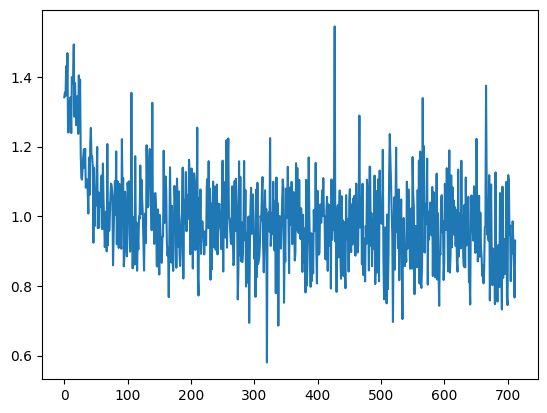

In [154]:
plt.plot(Loss)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 228, 228])


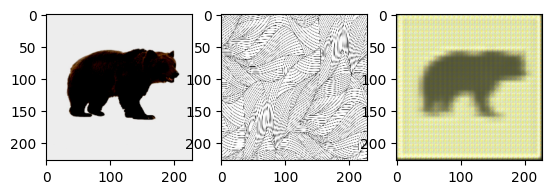

In [155]:
model.eval()
gener.eval()
with torch.no_grad():
    correct=0
    total=0
    for _,(img,label) in enumerate(test_loader):
        #img = torch.Tensor(np.abs(np.fft.fft2(img)))
        img=img.to(device)
        label=label.to(device)
        gimg = gener(img)
#         outputs=model(gimg)
#         _,predict=torch.max(outputs.data,1)
#         correct+=(predict==label).sum().item()
#         total+=label.size(0)
        print(style_img.shape)
        plt.subplot(1,3,1)
        plt.imshow(img.cpu().permute(0,2,3,1).numpy()[0])
        plt.subplot(1,3,2)
        plt.imshow(style_img.cpu().permute(1,2,0).numpy())
        plt.subplot(1,3,3)
        plt.imshow(gimg.cpu().permute(0,2,3,1).numpy()[0])
        break
#print("在{}个图片中测试正确率为：{}%".format(total,100*correct/total))

In [ ]:
torch.save(model.state_dict(), './checkpoint/Resmodel.pt')

In [121]:
torch.save(gener.state_dict(), './checkpoint/mysample.pt')